# Project - Why So Harsh?

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import re

from wordcloud import WordCloud
from matplotlib import pyplot as plt
%matplotlib inline

!pip install contractions
import contractions

!pip install emot
from emot.emo_unicode import EMOTICONS_EMO

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 2.4 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


## Collecting the data from the datasets

In [2]:
train_data = pd.read_csv('../input/harsh-comment-classification/train.csv')
test_data = pd.read_csv('../input/harsh-comment-classification/test.csv')

## Exploratory Data Analysis (EDA)

In [3]:
train_data.head()

,id,text,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
0,a8be7c5d4527adbbf15f,""", 6 December 2007 (UTC)\nI am interested, not...",0,0,0,0,0,0
1,0b7ca73f388222aad64d,I added about three missing parameters to temp...,0,0,0,0,0,0
2,db934381501872ba6f38,SANDBOX?? \n\nI DID YOUR MADRE DID IN THE SANDBOX,1,0,0,0,0,0
3,228015c4a87c4b1f09a7,"why good sir? Why? \n\nYou, sir, obviously do ...",1,0,1,1,1,0
4,b18f26cfa1408b52e949,"""\n\n Source \n\nIncase I forget, or someone e...",0,0,0,0,0,0


In [4]:
train_data.describe()

,harsh,extremely_harsh,vulgar,threatening,disrespect,targeted_hate
count,89359.000000,89359.000000,89359.000000,89359.000000,89359.000000,89359.000000
mean,0.095782,0.010262,0.053067,0.002999,0.049150,0.008975
std,0.294294,0.100781,0.224168,0.054683,0.216182,0.094311
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
print("Train Data: ")
print(train_data.isna().sum())

Train Data: 
id                 0
text               0
harsh              0
extremely_harsh    0
vulgar             0
threatening        0
disrespect         0
targeted_hate      0
dtype: int64


In [6]:
train_data.duplicated().sum()

0

In [7]:
print("Train Data: ")
print((train_data == "?").sum())

Train Data: 
id                 0
text               0
harsh              0
extremely_harsh    0
vulgar             0
threatening        0
disrespect         0
targeted_hate      0
dtype: int64


In [8]:
print("Train Data: ")
print(train_data.nunique())

Train Data: 
id                 89359
text               89359
harsh                  2
extremely_harsh        2
vulgar                 2
threatening            2
disrespect             2
targeted_hate          2
dtype: int64


In [9]:
train_data.shape

(89359, 8)

In [10]:
Columns = ['harsh', 'extremely_harsh', 'vulgar', 'threatening', 'disrespect', 'targeted_hate']
Column_values = []
print("Train Data: ")
for col in Columns:
    Column_values.append(train_data[col].sum())
    print(train_data[col].value_counts())

Train Data: 
0    80800
1     8559
Name: harsh, dtype: int64
0    88442
1      917
Name: extremely_harsh, dtype: int64
0    84617
1     4742
Name: vulgar, dtype: int64
0    89091
1      268
Name: threatening, dtype: int64
0    84967
1     4392
Name: disrespect, dtype: int64
0    88557
1      802
Name: targeted_hate, dtype: int64


### Distribution of the labels

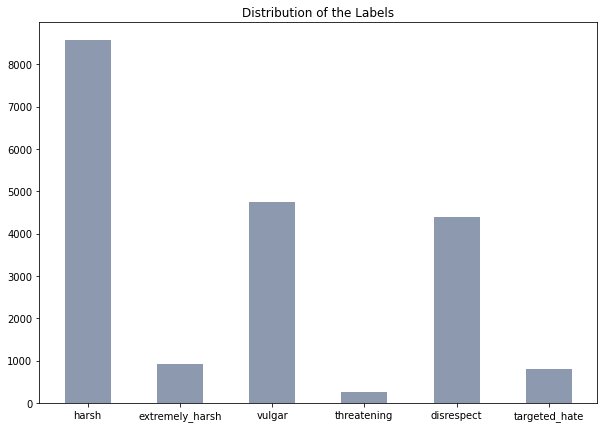

In [11]:
fig = plt.figure(figsize = (10, 7))
 
# creating the bar plot
plt.bar(Columns, Column_values, color ='#8d99ae', width = 0.5)
 
plt.title("Distribution of the Labels")
plt.show()

### WordCloud

This gives the image composed of words that are used in a specific column, where the size of each word denotes its frequency or significance.

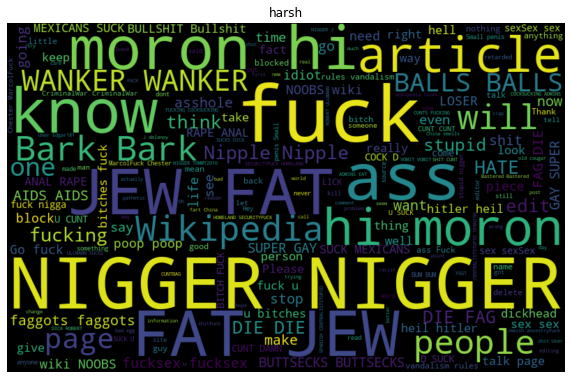

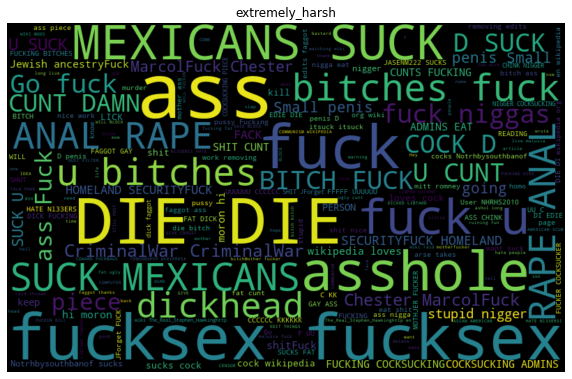

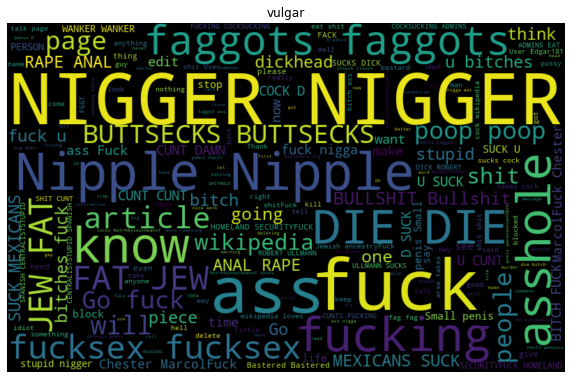

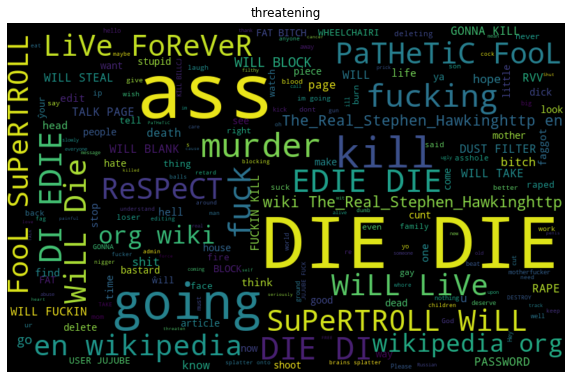

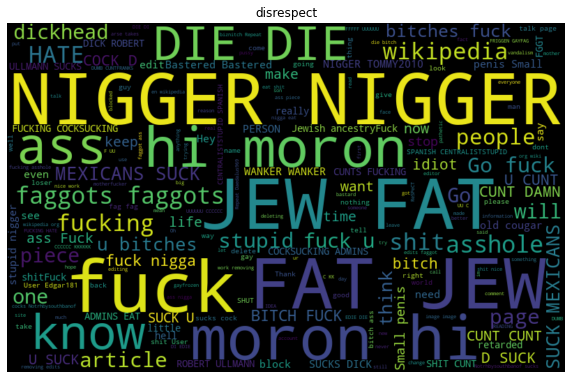

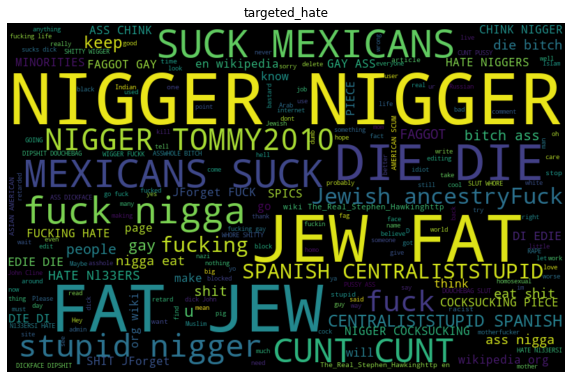

In [12]:
for col in Columns:
    all_words = ' '.join([comment for comment in train_data['text'][train_data[col] == 1]])
    wordcloud = WordCloud(
                width=800, height=500, 
                background_color = 'black',
                max_font_size = 110,
                random_state=91).generate(all_words)
    
    plt.figure(figsize=(10, 7))
    plt.title(col)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

## Pre-processing on data

In [13]:
train_text_list = train_data["text"].tolist()
test_text_list = test_data["text"].tolist()

### 1. Expand contractions in Text Processing

In [14]:
def expand_contractions(text_list):
    for i in range(len(text_list)):
        expanded_sentence = ''
        for word in text_list[i].split():
            try:
                expanded_sentence += contractions.fix(word)+' ' 
            except:
                print(word, len(word))
        text_list[i] = expanded_sentence
    
    return text_list

### 2. Emoticon ‘:-)’ handling in Text Processing

In [15]:
def handle_emoticons(text_list):
    for i in range(len(text_list)):
        sentence = text_list[i]
        for emotes in EMOTICONS_EMO:
            sentence = sentence.replace(emotes, " "+EMOTICONS_EMO[emotes].replace(" ","_"))
            text_list[i] = sentence
    
    return text_list

### 3. Clean-up & Normalizing the Text

In [16]:
# 1. Converting upper-case characters to lower-case
# 2. Removing all the Punctuation characters from text execpt '?', '!' 
# 3. Removing all extra spaces between words

def clean_up(text_list):
    for i in range(len(text_list)):
        text_list[i] = text_list[i].lower() 
        text_list[i] = re.sub('[^a-z ?!]+', ' ', text_list[i])
        text_list[i] = re.sub(r'\s+', ' ', text_list[i])
    
    return text_list

### 4. Stopwords removal

In [17]:
def stopwords_removal(text_list):
    stop_words = set(stopwords.words('english'))
    
    # Stopwords for removing url's
    stop_words.add('www')
    stop_words.add('http')
    stop_words.add('https')

    for i in range(len(text_list)):
        word_tokens = word_tokenize(text_list[i])
        filtered_words = [w for w in word_tokens if w not in stop_words]
        text_list[i] = ' '.join(filtered_words)
    
    return text_list

### 5. Lemmatizing the Text using PoS-Tagging

In [18]:
def get_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    else:         
        return wordnet.NOUN

def lemmatizing(text_list):
    lemmatizer = WordNetLemmatizer()
    for i in range(len(text_list)):
        lemmatized_sentence = []
        pos_tagged = nltk.pos_tag(nltk.word_tokenize(text_list[i]))
        word_tagged = list(map(lambda x: (x[0], get_pos_tagger(x[1])), pos_tagged))
        for word, tag in word_tagged:      
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
        text_list[i] = " ".join(lemmatized_sentence)
        
    return text_list

In [19]:
# Expand contractions
train_text_list = expand_contractions(train_text_list)
test_text_list = expand_contractions(test_text_list)

İletişim 8
İtburnu 7


In [20]:
# Emoticons handling
train_text_list = handle_emoticons(train_text_list)
test_text_list = handle_emoticons(test_text_list)

In [21]:
# Cleaning and Normalizing the Text
train_text_list = clean_up(train_text_list)
test_text_list = clean_up(test_text_list)

In [22]:
# Stopwords removal
train_text_list = stopwords_removal(train_text_list)
test_text_list = stopwords_removal(test_text_list)

In [23]:
# Lemmatization
train_text_list = lemmatizing(train_text_list)
test_text_list = lemmatizing(test_text_list)

### 6. Vectorization of words using TF-IDF

In [24]:
# TF-IDF Vectorization of words
word_vect = TfidfVectorizer(strip_accents = 'unicode',
                            ngram_range = (1, 2),
                            stop_words ='english',
                            analyzer = 'word')
    
train_features = word_vect.fit_transform(train_text_list)
test_features = word_vect.transform(test_text_list)

## Model Implementation

### 1. Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

pred_df = {
    'id' : test_data['id']
}

# model = LogisticRegression(class_weight='balanced')
model = LogisticRegression(class_weight = 'balanced')

for i in Columns:
    model.fit(train_features, train_data[i].to_numpy())
    y_pred = model.predict_proba(test_features)[:, 1]
    pred_df[i] = y_pred
    
df_submit = pd.DataFrame(pred_df)
df_submit.to_csv('final_submission.csv', index=None)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
